In [24]:
%matplotlib inline


import pandas as pd

base_path = '../Backtests/'

bm = 'SPXTR'
bm_name = 'S&P 500 Total Return Index'


strat_names = {
    "core_trend" : "Core Trend Strategy",    
    "time_return" : "Time Return Strategy",
    "counter_trend" : "Counter Trend Strategy",
    "curve_trading" : "Curve Trading Strategy",
    "equity_momentum" : "Equity Momentum Strategy",
}

strat = 'curve_trading'
strat_name = strat_names[strat]

df = pd.read_csv(base_path + strat + '.csv', index_col=0, parse_dates=True, names=[strat] )
df[bm_name] = pd.read_csv(base_path + bm + '.csv', index_col=0, parse_dates=[0] )
df = df.loc[:'2018-12-31'].dropna()
print("Fetched: {}".format(strat_name))

Fetched: Curve Trading Strategy


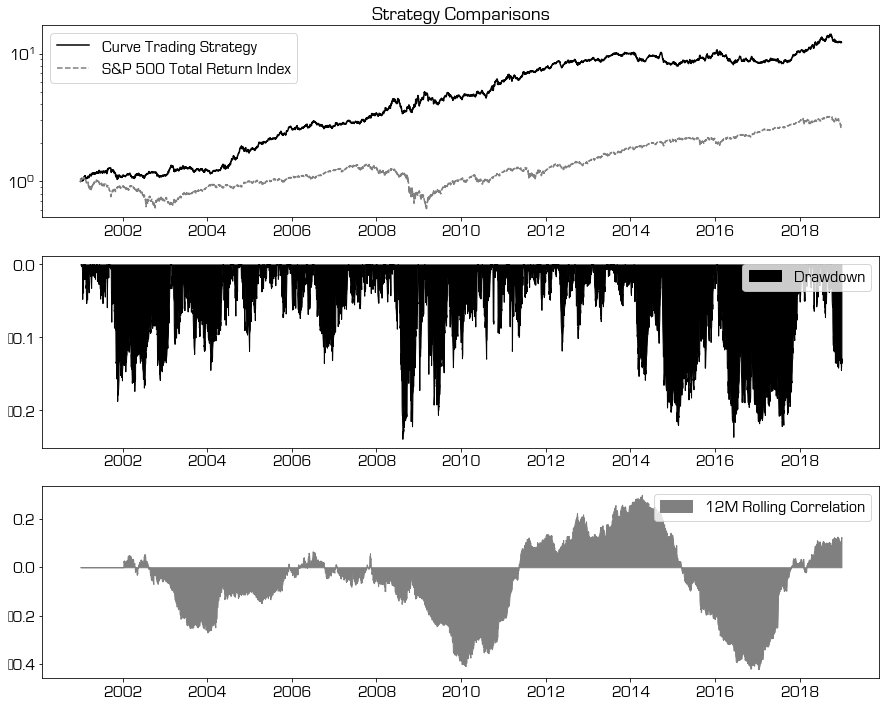

In [25]:
import matplotlib
import matplotlib.pyplot as plt
yr_periods = 252

# Format for book display
font = {'family' : 'eurostile',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

def equity_graph(df):
    df = df / df.iloc[0]
    df['Correlation'] = df[strat].pct_change().rolling(window=int(yr_periods / 1)).corr(df[bm_name].pct_change())
    
    df['Drawdown'] = (df[strat] / df[strat].cummax()) - 1
    
    df.fillna(0, inplace=True) # make sure no NA values are in there
    fig = plt.figure(figsize=(15, 12))

    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Comparisons')
    ax.semilogy(df[strat], '-',label=strat_name, color='black')
    ax.semilogy(df[bm_name] , '--', color='grey')
    ax.legend()
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.fill_between(df.index, df['Drawdown'], label='Drawdown', color='black')
    ax.legend()

    # Third chart
    ax = fig.add_subplot(313)
    ax.fill_between(df.index,df['Correlation'], label='12M Rolling Correlation', color='grey')
    ax.legend()

equity_graph(df)

In [26]:
import empyrical as em
from IPython.core.display import display, HTML

monthly_data = em.aggregate_returns(df[strat].pct_change(),'monthly')
yearly_data = em.aggregate_returns(df[strat].pct_change(),'yearly')

table = """
<table class='table table-hover table-condensed table-striped'>
<thead>
<tr>
<th style="text-align:right">Year</th>
<th style="text-align:right">Jan</th>
<th style="text-align:right">Feb</th>
<th style="text-align:right">Mar</th>
<th style="text-align:right">Apr</th>
<th style="text-align:right">May</th>
<th style="text-align:right">Jun</th>
<th style="text-align:right">Jul</th>
<th style="text-align:right">Aug</th>
<th style="text-align:right">Sep</th>
<th style="text-align:right">Oct</th>
<th style="text-align:right">Nov</th>
<th style="text-align:right">Dec</th>
<th style="text-align:right">Year</th>
</tr>
</thead>
<tbody>
<tr>"""

first_year = True
first_month = True
yr = 0
mnth = 0
for m, val in monthly_data.iteritems():
    yr = m[0]
    mnth = m[1]

    if(first_month):
        table += "<td align='right'><b>{}</b></td>\n".format(yr)
        first_month = False

    if(first_year): # pad empty months for first year if sim doesn't start in January
        first_year = False
        if(mnth > 1):
            for i in range(1, mnth):
                table += "<td align='right'>-</td>\n"

    table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)

    if(mnth==12): # check for dec, add yearly
        table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)     
        table += '</tr>\n <tr> \n'    
        first_month = True

# add padding for empty months and last year's value
if(mnth != 12):
    for i in range(mnth+1, 13):
        table += "<td align='right'>-</td>\n"
        if(i==12):
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(
                yearly_data[yr] * 100
            ) 
            table += '</tr>\n <tr> \n'
table += '</tr>\n </tbody> \n </table>'

display(HTML(table))


Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
2001,+4.2,+1.4,+5.8,+2.5,+2.7,+2.5,-3.0,+7.7,-3.1,-7.0,-2.3,-0.1,+10.7
2002,+0.6,+3.0,-6.0,+6.1,-2.1,-1.0,+4.1,+0.8,+0.9,-3.7,-2.6,+2.2,+1.7
2003,+5.1,+11.4,-5.5,-1.5,+5.6,+0.3,-0.8,-3.8,+0.3,-0.3,-2.0,+0.1,+8.1
2004,-4.2,+4.2,-0.3,+5.3,-0.5,+3.1,+15.3,-2.1,+12.9,+11.7,-2.0,-5.7,+41.2
2005,+5.7,-0.6,+10.6,-0.2,+3.5,+4.5,+0.5,+6.0,+4.3,-0.2,+7.3,+1.2,+51.1
2006,-1.6,+0.4,+3.1,+3.1,-1.2,+7.5,-1.5,-4.7,-0.7,-1.9,+1.2,+1.0,+4.2
2007,+1.2,+2.5,+1.1,+4.8,-2.6,+0.4,-1.6,+5.3,+1.9,+5.1,+2.2,+2.0,+24.2
2008,-1.0,+3.8,+5.2,+2.7,+15.2,-1.1,-11.4,-4.5,+5.9,-6.8,+8.9,+9.7,+26.3
2009,+5.9,+6.0,-5.4,+0.1,-6.7,+1.2,+1.6,+10.5,-1.3,-4.8,+0.8,+0.8,+7.3
2010,+6.4,-3.0,+0.4,-1.6,+6.0,+3.0,-8.3,+6.8,+7.9,+14.3,-5.2,+6.6,+36.1


In [4]:
def holding_period_map(df):
    yr = em.aggregate_returns(df[strat].pct_change(), 'yearly')
    df = pd.DataFrame(columns=range(1,len(yr)+1), index=yr.index)

    yr_start = 0
    
    table = "<table class='table table-hover table-condensed table-striped'>"
    table += "<tr><th>Years</th>"
    
    for i in range(len(yr)):
        table += "<th>{}</th>".format(i+1)
    table += "</tr>"

    for the_year, value in yr.iteritems(): # Iterates years
        table += "<tr><th>{}</th>".format(the_year) # New table row
        
        for yrs_held in (range(1, len(yr)+1)): # Iterates yrs held 
            if yrs_held   <= len(yr[yr_start:yr_start + yrs_held]):
                ret = em.annual_return(yr[yr_start:yr_start + yrs_held], 'yearly' )
                table += "<td>{:+.0f}</td>".format(ret * 100)
        table += "</tr>"    
        yr_start+=1
    return table

table = holding_period_map(df)
display(HTML(table))
